### Fed Z.1 Report

In [2]:
%config Completer.use_jedi = False
import sys
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

### Change in liabilities

In [2]:
n = {'Total': 'Total',
     'FL104190005.Q': '\hspace{-2mm}\cbox{lime!70}Corporate Business',
     'FL104122005.Q': '\hspace{4mm} Debt Securities',
     'FL104123005.Q': '\hspace{4mm} Loans',
     'FL114190005.Q': '\hspace{-2mm}\cbox{green!72!black}Non-corporate Business',
     'FL113165505.Q': '\hspace{4mm} Commercial Mortgages',
     'FL154190005.Q': '\hspace{-2mm}\cbox{orange!70}Household \& Nonprofit',
     'FL153165105.Q': '\hspace{4mm} Home Mortgages',
     'FL153166000.Q': '\hspace{4mm} Consumer Credit',
     'FL214190005.Q': '\hspace{-2mm}\cbox{cyan!52}State \& Local Government',
     'FL314190005.Q': '\hspace{-2mm}\cbox{blue!70}Federal Government'}

In [3]:
base = 'https://www.federalreserve.gov/datadownload/Output.aspx?'
srs = 'rel=Z1&series=b682bef8ceb8d78b170ce12e692f06dc&lastobs=&' 
dt = 'from=03/01/1988&to=12/31/2021&'
oth = 'filetype=csv&label=include&layout=seriescolumn'

d, df = clean_fed_data(base + srs + dt + oth)
subseries = ['FL104190005.Q', 'FL114190005.Q', 'FL154190005.Q', 
             'FL214190005.Q', 'FL314190005.Q']
df['Total'] = df[subseries].sum(axis=1)
df.to_csv(data_dir / 'liab_z1_raw.csv', index_label='date')

In [4]:
df = pd.read_csv(data_dir / 'liab_z1_raw.csv', index_col='date', 
                 parse_dates=True)
sh = (df.div(nipa_df(retrieve_table('T10105')['Data'], ['A191RC']
                    )['A191RC'], axis=0)).dropna().loc['1989':] * 100
sh['Business'] = sh[['FL104190005.Q', 'FL114190005.Q']].sum(axis=1)
sh.to_csv(data_dir / 'liabsh.csv', index_label='date')

s = [('Business', 'green!72!black', 'q'), 
     ('FL154190005.Q', 'orange!90!red', None), 
     ('FL214190005.Q', 'cyan!60!white', None), 
     ('FL314190005.Q', 'blue!70!white', None)]
nodes = '\n'.join([end_node(sh[i], c, percent=True, date=d, size=1.2) 
                   for i, c, d in s]).replace('\\\ \scriptsize Q', ' Q')
write_txt(text_dir / 'liabsh_node.txt', nodes)

dt = dtxt(sh.index[-1])
bt = df[['FL104190005.Q', 'FL114190005.Q']].iloc[-1].sum() / 1_000_000
lt = {name: f'{val:.1f} percent' for name, val 
      in sh.iloc[-1].to_dict().items()}
lt19 = {name: f'{val:.1f} percent' for name, val 
        in sh.loc['2019'].mean().to_dict().items()}
lt90 = {name: f'{val:.1f} percent' for name, val 
        in sh.loc['1990':'1999'].mean().to_dict().items()}
cl = {name: c_line(color) for name, color, _ in s}
text = ('Private business liabilities, corporate- and non-corporate, '+
        f'total \${bt:.1f} trillion in {dt["qtr2"]}, '+
        f'equivalent to {lt["Business"]} of GDP {cl["Business"]}. In 2019, '+
        f'business liabilities were equivalent to {lt19["Business"]} '+
        f'of GDP, and during the 1990s they were {lt90["Business"]} of '+
        'GDP, on average. Private household and nonprofit liabilities '+
        f'are equivalent to {lt["FL154190005.Q"]} of GDP in {dt["qtr1"]} '+
        f'{cl["FL154190005.Q"]}, {lt19["FL154190005.Q"]} in 2019, and '+
        f'{lt90["FL154190005.Q"]} in the 1990s.\n\nFederal government '+
        f'liabilities are equivalent to {lt["FL314190005.Q"]} of GDP in '+
        f'{dt["qtr1"]} {cl["FL314190005.Q"]}, compared to '+
        f'{lt19["FL314190005.Q"]} of GDP in 2019 and {lt90["FL314190005.Q"]} '+
        'of GDP during the 1990s. Combined state and local government '+
        f'liabilities total {lt["FL214190005.Q"]} of GDP in {dt["qtr1"]} '+
        f'{cl["FL214190005.Q"]}, {lt19["FL214190005.Q"]} in 2019, and '+
        f'{lt90["FL214190005.Q"]} in the 1990s.')
write_txt(text_dir / 'liabsh.txt', text)
print(text, '\n')

data = df.join(nipa_df(retrieve_table('T20304')['Data'], ['DPCERG'])['DPCERG'])
pr = data.DPCERG / data.DPCERG.iloc[-1]
real = data.divide(pr, axis=0).drop('DPCERG', axis=1)
res = growth_contrib_ann(real, 'Total').dropna()
res.to_csv(data_dir / 'liabgr.csv', index_label='date')
s = [('fed', 'blue!70', 'FL314190005.Q'), ('slg', 'cyan!52', 'FL214190005.Q'), 
     ('hh', 'orange!70', 'FL154190005.Q'), ('cb', 'lime!70', 'FL104190005.Q'), 
     ('ncb', 'green!72!black', 'FL114190005.Q')]
cbox = {name: c_box(color) for name, color, _ in s}
tot = value_text(res.Total.iloc[-1], threshold=0.1, obj='plural')
stypes = [('contribution', '1'), ('contribution_to', '2')]
txt = {f'{name}{i}': value_text(res[col].iloc[-1], style, digits=2,
                                ptype='pp', threshold=0.1) 
       for style, i in stypes for name, _, col in s}
text = (f'Total domestic liabilities {tot} over the year ending '+
        f'{dt["qtr1"]}, after adjusting for inflation. Federal government '+
        f'borrowing {txt["fed2"]} the total {cbox["fed"]}, while the '+
        f'state and local government {txt["slg1"]} {cbox["slg"]}. Households '+
        f'and nonprofits {txt["hh1"]} to total annual growth {cbox["hh"]}, '+
        f'corporate businesses {txt["cb1"]} {cbox["cb"]}, and non-corporate '+
        f'businesses {txt["ncb1"]} {cbox["ncb"]}.')
write_txt(text_dir / 'liabgr.txt', text)
print(text)

result = res[n.keys()]
tbl = result.iloc[-5:].iloc[::-1].T
cols = [f' {q.year} Q{q.quarter}' 
        if i == 0 else f'`{str(q.year)[2:]} Q{q.quarter}'
        for i, q in enumerate(tbl.columns)]

tbl.columns = cols
tbl['3-year'] = result.rolling(13).mean().iloc[-1].round(2)
tbl['10-year'] = result.rolling(41).mean().iloc[-1].round(2)
tbl['30-year'] = result.rolling(121).mean().iloc[-1].round(2)
tbl.index = tbl.index.map(n)
tbl = tbl.applymap('{:.2f}'.format)
tbl.to_csv(data_dir / 'liabgr.tex', sep='&', line_terminator='\\\ ', 
            quotechar=' ')

Private business liabilities, corporate- and non-corporate, total \$35.3 trillion in the fourth quarter of 2021, equivalent to 147.2 percent of GDP (see {\color{green!72!black}\textbf{---}}). In 2019, business liabilities were equivalent to 144.2 percent of GDP, and during the 1990s they were 99.6 percent of GDP, on average. Private household and nonprofit liabilities are equivalent to 76.4 percent of GDP in 2021 Q4 (see {\color{orange!90!red}\textbf{---}}), 76.0 percent in 2019, and 64.2 percent in the 1990s.

Federal government liabilities are equivalent to 116.8 percent of GDP in 2021 Q4 (see {\color{blue!70!white}\textbf{---}}), compared to 98.6 percent of GDP in 2019 and 66.2 percent of GDP during the 1990s. Combined state and local government liabilities total 33.4 percent of GDP in 2021 Q4 (see {\color{cyan!60!white}\textbf{---}}), 39.4 percent in 2019, and 26.8 percent in the 1990s. 

Total domestic liabilities decreased 0.7 percent over the year ending 2021 Q4, after adjusting

### Wealth to GDP


In [5]:
url = ('https://www.federalreserve.gov/datadownload/Output.aspx?'+
       'rel=Z1&series=2ce5701b67d5c62df54fe8fc8312f49c&lastobs=&'+
       'from=03/01/1988&to=12/31/2021&filetype=csv&label=include&'+
       'layout=seriescolumn')
d, df = clean_fed_data(url)
df.to_csv(data_dir / 'uswealth_raw.csv', index_label='date')

In [6]:
df = pd.read_csv(data_dir / 'uswealth_raw.csv', index_col='date',
                 parse_dates=True)
d2 = {'FL264090005.Q': '\hspace{5mm} Less: ROW Claims on US',
      'FL882090265.Q': '\hspace{2mm} Net Claims on ROW',
      'FL892090005.Q': 'US Net Wealth',
      'LM112010005.Q': 'nfncb',
      'LM152010005.Q': '\hspace{2mm} Households \& Nonprofits',
      'LM212010095.Q': '\hspace{2mm} State \& Local Government',
      'LM315015005.Q': '\hspace{2mm} Federal Government',
      'LM662090003.Q': 'fncb',
      'LM882010405.Q': '\hspace{2mm} Domestic Corporations',
      'FL264194005.Q': '\hspace{5mm} US Claims on ROW',
      'LM155035005.Q': 'Real Estate', 
      'LM883164105.Q': 'Corporate Equities'}
data = df.rename(d2, axis=1)
data['\hspace{2mm} Noncorporate Businesses'] = data['nfncb'] + data['fncb']
data['Other'] = (data['US Net Wealth'] - data['Real Estate']
                 - data['Corporate Equities'])
gdp = nipa_df(retrieve_table('T10105')['Data'], ['A191RC'])['A191RC']
ro = ['US Net Wealth', '\hspace{2mm} Households \& Nonprofits', 
      '\hspace{2mm} Noncorporate Businesses', 
      '\hspace{2mm} Domestic Corporations', '\hspace{2mm} Federal Government', 
      '\hspace{2mm} State \& Local Government', 
      '\hspace{2mm} Net Claims on ROW', '\hspace{5mm} US Claims on ROW', 
      '\hspace{5mm} Less: ROW Claims on US']
dsh = (data.div(gdp, axis=0) * 100).dropna()
res = dsh.loc[:,ro]

tbl = res.iloc[-3:].iloc[::-1].T
tbl[res.index[-5]] = res.iloc[-5]
cols = [f' {q.year} Q{q.quarter}' 
        if i == 0 else f'`{str(q.year)[2:]} Q{q.quarter}'
        for i, q in enumerate(tbl.columns)]

tbl.columns = cols
tbl['2019'] = res.loc['2019'].mean()
tbl['2005 --`07'] = res.loc['2005':'2007'].mean()
tbl['1989'] = res.loc['1989'].mean()
tbl = tbl.applymap('{:.1f}'.format)
tbl.to_csv(data_dir / 'uswealth.tex', sep='&', line_terminator='\\\ ', 
            quotechar=' ')

# Text
ltdt = dtxt(res.index[-1])['qtr1']
pop = nipa_df(retrieve_table('T20100')['Data'], ['B230RC'])['B230RC']
pc = (data['US Net Wealth'].divide(pop, axis=0)).dropna() * 1000
pcv = f'\${pc.iloc[-1].round(-2):,.0f}'
ltval = data['US Net Wealth'].iloc[-1] / 1_000_000
ltsh = res['US Net Wealth'].iloc[-1]

text = (f'US wealth totals \${ltval:.1f} trillion in {ltdt}, '+
        f'equivalent to {pcv} per capita, or a {ltsh / 100:.2f} '+
        f'multiple of GDP ({ltsh:.1f} percent of GDP.)')
write_txt(text_dir / 'uswealth.txt', text)
print(text)

keep = ['Corporate Equities', 'Real Estate', 'Other', 
        'US Net Wealth']
dft = dsh.loc['1989':, keep].divide(100)
dft.to_csv(data_dir / 'wealthgdp.csv', index_label='date')
tot = dft['US Net Wealth']
ltval = tot.iloc[-1]
t89 = tot.loc['1989'].mean()
cht = value_text((ltval - t89) * 100, ptype='pp')
ce = dft['Corporate Equities']
ce89 = ce.loc['1989'].mean()
ce99 = ce.loc['1999': '2000'].mean()
rr = dft['Real Estate']
rr89 = rr.loc['1989'].mean()
rr05 = rr.loc['2005': '2007'].mean()
ot = dft['Other']
ot89 = ot.loc['1989'].mean()

ceb = c_box('magenta!50!violet')
reb = c_box('green!80!blue')
otb = c_box('cyan!35!white')

txt = (f'The ratio of US wealth to GDP has {cht} since 1989, driven '+
       f'largely by increases in the market value of corporate '+
       'equities and residential real estate. The market value of '+
       f'corporate equities was equivalent to a {ce.iloc[-1]:.2f} '+
       f'multiple of GDP in {ltdt}, compared to {ce99:.2f} in 1999--'+
       f'2000, during the tech bubble, and to {ce89:.2f} in 1989 {ceb}. '+
       f'The market value of domestic residential real estate was '+
       f'equivalent to a {rr.iloc[-1]:.2f} multiple of GDP in {ltdt}, '+
       f'compared to {rr05:.2f} in 2005--2007, during the housing bubble, '+
       f'and {rr89:.2f} in 1989 {reb}.\n\nOn a net basis, all other US '+
       f'wealth is equivalent to a {ot.iloc[-1]:.2f} multiple of GDP '+
       f'in {ltdt} and a {ot89:.2f} multiple in 1989 {otb}. The other '+
       'category includes tangible assets of noncorporate businesses and '+
       'governments, and domestic financial claims on foreign assets. The '+
       'category also subtracts foreign financial claims on US assets, '+
       'for example foreign holdings of US corporate equities and '+
       'Treasury bonds.')
write_txt(text_dir / 'wealthgdp.txt', txt)
print(txt)

US wealth totals \$137.1 trillion in 2021 Q4, equivalent to \$412,200 per capita, or a 5.71 multiple of GDP (571.0 percent of GDP.)
The ratio of US wealth to GDP has increased 185.5 percentage points since 1989, driven largely by increases in the market value of corporate equities and residential real estate. The market value of corporate equities was equivalent to a 2.84 multiple of GDP in 2021 Q4, compared to 1.70 in 1999--2000, during the tech bubble, and to 0.60 in 1989 (see\cbox{magenta!50!violet}). The market value of domestic residential real estate was equivalent to a 1.77 multiple of GDP in 2021 Q4, compared to 1.85 in 2005--2007, during the housing bubble, and 1.34 in 1989 (see\cbox{green!80!blue}).

On a net basis, all other US wealth is equivalent to a 1.10 multiple of GDP in 2021 Q4 and a 1.91 multiple in 1989 (see\cbox{cyan!35!white}). The other category includes tangible assets of noncorporate businesses and governments, and domestic financial claims on foreign assets. T

### Business Debt

In [7]:
base = 'https://www.federalreserve.gov/datadownload/Output.aspx?'
srs = 'rel=Z1&series=d720788442f3511d102b43eee2bddb41&lastobs=&'
dt = 'from=03/01/1988&to=12/31/2021&'
oth = 'filetype=csv&label=include&layout=seriescolumn'
url = base + srs + dt + oth

d = {'FL104122005.Q': 'Debt Securities',
     'FL143168005.Q': 'Bank Loans',
     'FL143165005.Q': 'Mortgages',
     'FL143169005.Q': 'Nonbank Loans',
     'FL144104005.Q': 'Total',
     'FL104104005.Q': 'Total Corporate',
     'FL114123005.Q': 'Total Noncorporate',
     'FL794122005.Q': 'Financial Debt Securities',
     'FL794123005.Q': 'Financial Loans',
     'FL794104005.Q': 'Financial Total',
     'FL423161705.Q': 'Agency MBS'}

df = pd.read_csv(url, skiprows=5, index_col=0)[d.keys()].rename(d, axis=1)
df.index = pd.to_datetime(df.index)
df['Bank Loans and Mortgages'] = df['Bank Loans'] + df['Mortgages']
df['Other'] = df['Financial Debt Securities'] - df['Agency MBS']

data = (df.div(nipa_df(retrieve_table('T10105')['Data'], ['A191RC']
               )['A191RC'], axis=0)).dropna() * 100
data.loc['1989':].to_csv(data_dir / 'busdebtgdp2.csv', index_label='date', 
                         float_format='%g')

In [8]:
lt_date = f'{data.index[-1].year} Q{data.index[-1].quarter}'
total = df['Total'].iloc[-1] / 1_000
corp = df['Total Corporate'].iloc[-1] / 1_000
corp_sh = corp / total * 100
tot_gdp = data['Total'].iloc[-1]
tot_gdp_3 = data['Total'].iloc[-13]

date_3 = f'{data.index[-13].year} Q{data.index[-13].quarter}'
tot_3 = tot_gdp - tot_gdp_3
ds_3 = data['Debt Securities'].iloc[-1] - data['Debt Securities'].iloc[-13]
nb_3 = data['Nonbank Loans'].iloc[-1] - data['Nonbank Loans'].iloc[-13]

if tot_3 >= 1:
    tot_text = 'increased faster than'
    tot_text2 = 'increased'
elif (tot_3 < 1) & (tot_3 >= -1):
    tot_text = 'grown at about the same rate as'
    tot_text2 = 'grew'
else:
    tot_text = 'fallen relative to'
    tot_text2 = 'fell'
    
finmax = data['Financial Total'].max()
finmaxdt = f'{data["Financial Total"].idxmax().year} Q{data["Financial Total"].idxmax().quarter}'
finlt = data['Financial Total'].iloc[-1]

In [9]:
busdebt = (f'As of {lt_date}, nonfinancial business debt--the debt security '+
           'and loan liabilities of nonfinancial businesses--both corporate and '+
           f'non-corporate--totals \${total:,.0f} billion, with \${corp:,.0f} '+
           f'billion ({corp_sh:,.1f}\%) held by corporate businesses. Over the '+
           f'past three years, nonfinancial business debt has {tot_text} overall '+
           'economic activity. As a share of GDP, nonfinancial business debt '+
           f'{tot_text2} by {tot_3:.1f} percentage points to {tot_gdp:.1f} percent '+
           f'in {lt_date} from {tot_gdp_3:.1f} percent in {date_3}. The vast '+
           f'majority of the increase, {nb_3:.1f} percentage points, comes from '+
           'nonbank loans (see\\cbox{{blue}}).')
write_txt(text_dir / 'busdebtgdp.txt', busdebt)

fintext = ('Domestic financial sector debt has fallen as a share of '+
           f'GDP to {finlt:.1f} percent in {lt_date} from a housing-bubble '+
           f'peak of {finmax:.1f} percent in {finmaxdt}.')
write_txt(text_dir / 'findebtgdp.txt', fintext)

### Household debt

In [10]:
base = 'https://www.federalreserve.gov/datadownload/Output.aspx?'
srs = 'rel=Z1&series=21a69f49792f26a66791418647f75234&lastobs=&'
dt = 'from=03/01/1988&to=12/31/2021&'
oth = 'filetype=csv&label=include&layout=seriescolumn'
url = base + srs + dt + oth

d = {'FL153165105.Q': 'Mortgages',
     'FL153166000.Q': 'Consumer Credit',
     'FL154190005.Q': 'Total'}

df = (pd.read_csv(url, skiprows=5, index_col=0, parse_dates=True)[d.keys()]
        .rename(d, axis=1).divide(1000))
df['Other'] = df['Total'] - df['Consumer Credit'] - df['Mortgages']
table_store_fa = df.divide(1000)
dpi = nipa_df(retrieve_table('T20100')['Data'], ['A067RC'])['A067RC']
data = (df.div(dpi, axis=0)).dropna() * 100_000
data.loc['1989':].to_csv(data_dir / 'hhdebt.csv', index_label='date')
table_store_fa_dpi = data

In [11]:
date = dtxt(data.index[-1])['qtr1']
maxdate = dtxt(data.Total.idxmax())['qtr1']

totval = (df['Total'].iloc[-1] / 1000)
mortval = (df['Mortgages'].iloc[-1] / 1000)
mortsh = mortval / totval * 100
ccval = (df['Consumer Credit'].iloc[-1] / 1000)
ccsh = ccval / totval * 100
totrt = data['Total'].iloc[-1]
maxrt = data['Total'].max()
dpi3 = dpi.pct_change(12).iloc[-1] * 100
rt3 = df.Total.pct_change(12).iloc[-1] * 100
ch3 = data.Total.diff(12).iloc[-1]  
ch3txt = (value_text(ch3, style='increase_by', ptype='pp', threshold=0.3)
          .replace('decreased', 'fallen').replace('was', 'been'))
url = 'https://www.federalreserve.gov/releases/z1/current/default.htm'    
text1 = (f'The Federal Reserve \href{{{url}}}{{report}} household and '+
         f'nonprofit liabilities total \${totval:,.2f} trillion in {date}. '+
         f'The vast majority--\${mortval:,.2f} trillion or {mortsh:.1f} '+
         'percent of the total--are home mortgages (see\cbox{blue!60!violet}). '+
         'Consumer credit liabilities (see\cbox{magenta}) which include auto '+
         'loans, credit card debt, student loans, and other personal loans, '+
         f'total \${ccval:,.2f} trillion ({ccsh:.1f} percent of the total). The '+
         'remaining liabilities (see\cbox{orange!80!yellow}) are primarily '+
         'attributable to nonprofits.')

text2 = ('The ratio of household and nonprofit debt to disposable personal '+
         f'income has fallen to {totrt:.1f} percent in {date} from its '+
         f'housing-bubble peak of {maxrt:.1f} percent in {maxdate}. Over '+
         'the past three years, nominal household and nonprofit debt has '+
         f'{value_text(rt3, threshold=0.4)} while nominal disposable personal '+
         f'income has {value_text(dpi3, threshold=0.4)}. As a result, the '+
         'ratio of household and nonprofit debt to disposable personal income '+
         f'has {ch3txt}.')
write_txt(text_dir / 'hhdebt1.txt', text1)    
write_txt(text_dir / 'hhdebt2.txt', text2)
print(text1, '\n\n', text2)

The Federal Reserve \href{https://www.federalreserve.gov/releases/z1/current/default.htm}{report} household and nonprofit liabilities total \$18.35 trillion in 2021 Q4. The vast majority--\$11.74 trillion or 64.0 percent of the total--are home mortgages (see\cbox{blue!60!violet}). Consumer credit liabilities (see\cbox{magenta}) which include auto loans, credit card debt, student loans, and other personal loans, total \$4.43 trillion (24.2 percent of the total). The remaining liabilities (see\cbox{orange!80!yellow}) are primarily attributable to nonprofits. 

 The ratio of household and nonprofit debt to disposable personal income has fallen to 100.8 percent in 2021 Q4 from its housing-bubble peak of 136.6 percent in 2007 Q4. Over the past three years, nominal household and nonprofit debt has increased 14.7 percent while nominal disposable personal income has increased 14.4 percent. As a result, the ratio of household and nonprofit debt to disposable personal income has been virtually u

### Consumer Credit

In [12]:
if os.path.exists(data_dir / 'ccp_hist.csv'):
    h = pd.read_csv(data_dir / 'ccp_hist.csv', index_col='date', 
                    parse_dates=True)
else:
    # Historical data
    print('Retrieving historical data')
    url = ('https://www.newyorkfed.org/medialibrary/media/research/'+
           'national_economy/householdcredit/pre2003_data.xlsx')
    h = pd.read_excel(url, sheet_name='Total Balance Data', skiprows=2, 
                      nrows=6, usecols='A:S', index_col=0).dropna(axis=1).T
    h.index = pd.date_range(start='1999-01-01', end='2002-10-01', freq='QS')
    h.to_csv(data_dir / 'ccp_hist.csv', index_label='date')
    
# Download latest data    
d1 = pd.to_datetime('today') - pd.DateOffset(weeks=7)
dt1 = f'{d1.year}q{d1.quarter}.xlsx'
d2 = pd.to_datetime('today') - pd.DateOffset(weeks=20)
dt2 = f'{d2.year}q{d2.quarter}.xlsx'

def retrieve_frbny_data(dt):
    url = ('https://www.newyorkfed.org/medialibrary/interactives/'+
           f'householdcredit/data/xls/hhd_c_report_')
    return pd.read_excel(url+dt, sheet_name='Page 3 Data', 
                         header=3, index_col=0)

try:
    df = retrieve_frbny_data(dt1)
except ValueError:
    df = retrieve_frbny_data(dt2)
    print(f'{dt1} Not available. Using {dt2} instead.')
df.index = [pd.to_datetime(f'20{x.replace(":", "-")}') for x in df.index]
df = df.dropna(axis=1)    
data = h.append(df)
data['Mortgage Total'] = data['Mortgage'] + data['HE Revolving']
data['Consumer Credit'] = data['Total'] - data['Mortgage Total']
data.to_csv(data_dir / 'hhccpdebt.csv', index_label='date')

2022q1.xlsx Not available. Using 2021q4.xlsx instead.


In [13]:
data = pd.read_csv(data_dir / 'hhccpdebt.csv', index_col='date', 
                    parse_dates=True)
dpi = (nipa_df(retrieve_table('T20100')['Data'], ['A067RC'])
       .A067RC  / 1_000_000)
sh = (data.div(dpi, axis=0)).dropna(how='all') * 100
sh.loc['1999':].to_csv(data_dir / 'hhcdebt.csv', index_label='date')
ltdate = dtxt(sh.index[-1])['qtr1']
ltval = sh['Consumer Credit'].iloc[-1]
one_yr_diff = value_text(sh['Consumer Credit'].diff(4).iloc[-1], 
                         adj='total', ptype='pp')
cl = c_line('lime!55!green')
text = ('The latest comparable figure from the FRBNY data discussed in the '+
        f'previous section, which covers {ltdate}, shows consumer credit '+
        f'is equivalent to {ltval:.1f} percent of annual disposable '+
        f'personal income {cl}. Over the past year, the ratio {one_yr_diff}.')
write_txt(text_dir / 'cc_dpi_2.txt', text)
print(text)

st = end_node(sh['Student Loan'], 'green!80!blue', date='q', 
              full_year=True, offset=0.35, percent=True)
au = end_node(sh['Auto Loan'], 'blue!60!cyan', percent=True)
cc = end_node(sh['Credit Card'], 'red', percent=True)
nodes = '\n'.join([st, au, cc])
write_txt(text_dir / 'cc_nodes.txt', nodes)

c = [('Mortgage', 'gray'), ('HE Revolving', 'gray'), 
     ('Auto Loan', 'blue!60!cyan'), ('Credit Card', 'red'), 
     ('Student Loan', 'green!80!blue'), ('Total', 'gray')]
yr3ch = sh.diff(12).iloc[-1].sort_values(ascending=True)
d = dtxt(sh.index[-1])
d3 = dtxt(sh.index[-13])['qtr1']
cc_dates = d3 + '--' + d['qtr4']
write_txt(text_dir / 'cc_dates.txt', cc_dates)

bar = pd.DataFrame({'color': pd.Series({name: color for name, color in c}), 
                    'value': yr3ch}).dropna().sort_values('value')
bar.index.name = 'name'
bar.to_csv(data_dir / 'ccdebtbar.csv', index_label='name')

The latest comparable figure from the FRBNY data discussed in the previous section, which covers 2021 Q4, shows consumer credit is equivalent to 23.8 percent of annual disposable personal income (see {\color{lime!55!green}\textbf{---}}). Over the past year, the ratio decreased by a total of 0.3 percentage point.


In [14]:
# Consumer credit text
totval = data['Total'].iloc[-1]
totval2 = sh['Total'].iloc[-1]
totvalch = data['Total'].diff(12).iloc[-1]
tvdir = value_text(totvalch, 'increase_by', ptype='trillion', 
                   dollar=True, threshold=0.1, digits=2)
dpich = dpi.diff(12).iloc[-1]
dpidir = value_text(dpich, 'increase_of', ptype='trillion', 
                   dollar=True, threshold=0.1, digits=2)    
totvalch2 = sh['Total'].diff(12).iloc[-1]
tvdir2 = value_text(totvalch2, ptype='pp', threshold=0.1)
url = 'https://www.newyorkfed.org/microeconomics/hhdc/background.html'
txt = (f'Federal Reserve Bank of New York (FRBNY) \href{{{url}}}{{analysis}} '+
       f'of Equifax data shows \\${totval:.1f} trillion in total consumer '+
       f'debt in {d["qtr2"]}, which is equivalent to {totval2:.1f} percent '+
       f'of disposable personal income. Over the past three years, total '+
       f'consumer debt has {tvdir}, compared to {dpidir} in disposable personal '+
       f'income. As a result, the ratio of total consumer debt to disposable '+
       f'personal income {tvdir2} over this period.')
write_txt(text_dir / 'hhcdebt3.txt', txt)
print(txt)

Federal Reserve Bank of New York (FRBNY) \href{https://www.newyorkfed.org/microeconomics/hhdc/background.html}{analysis} of Equifax data shows \$15.6 trillion in total consumer debt in the fourth quarter of 2021, which is equivalent to 85.6 percent of disposable personal income. Over the past three years, total consumer debt has increased by \$2.03 trillion, compared to an increase of \$2.29 trillion in disposable personal income. As a result, the ratio of total consumer debt to disposable personal income increased 0.4 percentage point over this period.


In [15]:
tot, shr, gr = {}, {}, {}
for series in ['Mortgage Total', 'Auto Loan', 'Student Loan', 'Credit Card']:
    tot[series] = data[series].iloc[-1] * 1000
    shr[series] = sh[series].iloc[-1]
    grtmp = (sh[series].diff(12)).iloc[-1]
    gr[series] = value_text(grtmp, 'increase_of', ptype='pp', threshold=0.1)
        
mgr = sh['Mortgage Total'].diff(12).iloc[-1]        
gr['Mortgage Total'] = f'fell by {abs(mgr):.1f} percentage points'

txt3 = ('According to the same FRBNY data, mortgage debt, including home '+
        f'equity lines of credit, totalled \${tot["Mortgage Total"] / 1_000:,.2f} '+
        f'trillion in {d["qtr2"]}, equivalent to {shr["Mortgage Total"]:.1f} '+
        f'percent of disposable personal income (DPI). Student loans '+
        f'totalled \${tot["Student Loan"]:,.0f} billion, or '+
        f'{shr["Student Loan"]:.1f} percent of DPI; auto loans totalled '+
        f'\${tot["Auto Loan"]:,.0f} billion ({shr["Auto Loan"]:.1f} percent '+
        f'of DPI); and credit card debt totalled \${tot["Credit Card"]:,.0f} '+
        f'billion ({shr["Credit Card"]:.1f} percent of DPI).' )
write_txt(text_dir / 'hhcdebt4.txt', txt3)
print(txt3, '\n')
txt4 = ('Over the past three years, the ratio of total mortgage debt to disposable '+
        f'personal income {gr["Mortgage Total"]}, compared to '+
        f'{gr["Student Loan"]} for student loans, '+
        f'{gr["Auto Loan"]} for auto loans, and '+
        f'{gr["Credit Card"]} for credit card debt')
write_txt(text_dir / 'hhcdebt5.txt', txt4)
print(txt4)

According to the same FRBNY data, mortgage debt, including home equity lines of credit, totalled \$11.25 trillion in the fourth quarter of 2021, equivalent to 61.8 percent of disposable personal income (DPI). Student loans totalled \$1,576 billion, or 8.7 percent of DPI; auto loans totalled \$1,458 billion (8.0 percent of DPI); and credit card debt totalled \$856 billion (4.7 percent of DPI). 

Over the past three years, the ratio of total mortgage debt to disposable personal income fell by 1.9 percentage points, compared to a decrease of 0.5 percentage point for student loans, virtually no change for auto loans, and a decrease of 0.8 percentage point for credit card debt


In [16]:
# Household debt and consumer credit table
dtlt = pd.to_datetime(data.index[-1])
dt2 = pd.to_datetime(data.index[-2])
dt3y = pd.to_datetime(data.index[-13])
dt13 = pd.to_datetime('2013-01-01')
dt03 = pd.to_datetime('2003-01-01')

dts = [dtlt, dt2]
dts2 = [dtlt, dt2, dt3y, dt13, dt03]

for x in [data, sh]:
    x['Mortgage Total'] = x['Mortgage'] + x['HE Revolving']
    x['Non-Mortgage Total'] = (x['Auto Loan'] + x['Credit Card'] 
                               + x['Student Loan'] + x['Other'])

# Attempt to handle CCP coming out first
for x in [table_store_fa, table_store_fa_dpi]:
    if dtlt not in x.index:
        x.at[dtlt, :] = '--'

d1 = {'Total': 'Financial Accounts Total*',
      'Mortgages': '\hspace{2mm} \cbox{blue!60!violet} Mortgage Debt Total',
      'Consumer Credit': '\hspace{2mm} \cbox{magenta} Consumer Credit',
      'Other': '\hspace{2mm} \cbox{orange!80!yellow} Other'}

d2 = {'Total': 'Consumer Credit Panel Total',
      'Mortgage Total': '\hspace{2mm} Mortgage Debt Total',
      'Mortgage': '\hspace{4mm} Mortgage',
      'HE Revolving': '\hspace{4mm} Home Equity Revolving',
      'Non-Mortgage Total': '\hspace{2mm} Consumer Credit',
      'Auto Loan': '\hspace{4mm} \cbox{blue!60!cyan} Auto Loan',
      'Credit Card': '\hspace{4mm} \cbox{red} Credit Card',
      'Student Loan': '\hspace{4mm} \cbox{green!80!blue} Student Loan',
      'Other': '\hspace{4mm} Other'}

final = pd.DataFrame()

for dt in dts:
    dtmp = f'{dt.year} Q{dt.quarter}'
    for srs in [table_store_fa]:
        for k, v in d1.items():
            if srs.loc[dt, k] != '--':
                final.at[v, dtmp] = f'\${srs.loc[dt, k]:.2f}T'
            else: final.at[v, dtmp] = srs.loc[dt, k]
    for srs in [data]:
        for k, v in d2.items():            
            final.at[v, dtmp] = f'\${srs.loc[dt, k]:.2f}T' 
            
for dt in dts2:
    dtmp = f'`{str(dt.year)[2:]} Q{dt.quarter}'
    for srs in [table_store_fa_dpi]:
        for k, v in d1.items():
            if srs.loc[dt, k] != '--':
                final.at[v, dtmp] = round(srs.loc[dt, k], 1)
            else: 
                final.at[v, dtmp] = srs.loc[dt, k]
    for srs in [sh]:
        for k, v in d2.items():
            final.at[v, dtmp] = round(srs.loc[dt, k], 1)
            
final.to_csv(data_dir / 'hhcdebt.tex', sep='&', 
             line_terminator='\\\ ', quotechar=' ')

### Income as return on total HH assets

In [17]:
base = 'https://www.federalreserve.gov/datadownload/Output.aspx?'
srs = 'rel=Z1&series=906ccd6e7fcae1e4f20ac00b86ade272&lastobs=&'
dt = 'from=03/01/1988&to=12/31/2021&'
oth = 'filetype=csv&label=include&layout=seriescolumn'
url = base + srs + dt + oth

d = {'LM152010005.Q': 'Nonfinancial',
     'FL154090005.Q': 'Financial'}

df = pd.read_csv(url, skiprows=5, index_col=0, 
                 parse_dates=True)[d.keys()].rename(d, axis=1)
df['Total'] = df['Nonfinancial'] + df['Financial']
df['DPI'] = nipa_df(retrieve_table('T20100')['Data'], ['A067RC'])
df['DPINF'] = df['Nonfinancial'].divide(df['Total'], axis=0)
df['DPIF'] = df['Financial'].divide(df['Total'], axis=0)
df['DPIsh'] = df['DPI'].divide(df['Total'], axis=0)
df['DPINFsh'] = df['DPINF'] * df['DPIsh']
df['DPIFsh'] = df['DPIF'] * df['DPIsh']

df = df * 100
df.loc['1989':,'DPIsh'].to_csv(data_dir / 'dpish.csv', index_label='date')

node = end_node(df['DPIsh'], 'red', percent=True, date='q', 
                offset=0.35, full_year=True)
write_txt(text_dir / 'dpish_node.txt', node)

ltdate = dtxt(df.index[-1])['qtr1']
tot = df.DPIsh.iloc[-1]
tot90s = df.loc['1990':'1999', 'DPIsh'].mean()

text = (f'As of {ltdate}, disposable income was equivalent to {tot:.1f} '+
        'percent of total assets (see {\color{red}\\textbf{---}}), '+
        f'compared to an average rate of {tot90s:.1f} percent during '+
        'the 1990s.')
write_txt(text_dir / 'dpishta.txt', text)
print(text)

As of 2021 Q4, disposable income was equivalent to 10.8 percent of total assets (see {\color{red}\textbf{---}}), compared to an average rate of 16.0 percent during the 1990s.


### Household assets

In [18]:
base = 'https://www.federalreserve.gov/datadownload/Output.aspx?'
srs = 'rel=Z1&series=5f48b7338e558e73e11dc78be7354a87&lastobs=&'
dt = 'from=03/01/1988&to=12/31/2021&'
oth = 'filetype=csv&label=include&layout=seriescolumn'
url = base + srs + dt + oth
raw_data = pd.read_csv(url)

d = {v: re.sub("\s+[\(\[].*?[\)\]]", "", i.split('; ')[1]) 
     for i, v in raw_data.iloc[4, 1:].iteritems()}

date_column = raw_data.loc[5:, 'Series Description']
date_index = pd.to_datetime(date_column).rename('Date')
columns = raw_data.iloc[4, 1:].values
    
clean_data = raw_data.iloc[5:, 1:].replace('ND', np.nan).astype('float')
clean_data.index = date_index
clean_data.columns = columns

sel_col = ['FA156012005.Q', 'FL152000005.Q', 'LM152010005.Q', 'LM155035015.Q', 
           'FL155035065.Q', 'LM155111005.Q', 'FL154090005.Q', 'FL154000025.Q',
           'LM153064475.Q', 'LM152090205.Q']

names = ['DPI', 'TOT', 'NFA', 'HRE', 'REQ', 'CDG', 'TFA', 'DEP', 'CEQ', 'NEQ']

df = clean_data.loc[:,sel_col]
df.columns = names

df['NPA'] = clean_data.loc[:,['LM165013765.Q', 'LM165015205.Q', 'LM165035005.Q']].sum(axis=1)
df['DSL'] = clean_data.loc[:,['LM154022375.Q', 'FL154023005.Q']].sum(axis=1)
df['TEQ'] = df['NEQ'] + df['CEQ']
df['OFA'] = df['TFA'] - df['DEP'] - df['DSL'] - df['TEQ']
df['OTH'] = df['TOT'] - df['HRE'] - df['DEP'] - df['DSL'] - df['TEQ']

pce = nipa_df(retrieve_table('T20304')['Data'], ['DPCERG']).loc[df.index,'DPCERG']
pr = (pce / pce.iloc[-1])

gdp = nipa_df(retrieve_table('T10105')['Data'], ['A191RC']).loc[df.index,'A191RC']

dfgdp = df.div(gdp, axis=0).dropna() *100
dfgdp.loc['1989':].to_csv(data_dir / 'hhassetsgdp.csv', index_label='date', float_format='%g')

ldate = dtxt(df.index[-1])['qtr1']
pdate = dtxt(df.index[-5])['qtr1']
i = df.iloc[-1] / 1000000
g = dfgdp.iloc[-1] / 100
s = (df.div(df.TOT, axis=0) * 100).iloc[-1]

text = ('Assets '+
        f'of households and nonprofits were valued at \${i.TOT:.1f} trillion in {ldate}, '+
        f'equivalent to {g.TOT*100:.0f} percent--or {g.TOT:.3g} years--of GDP. '+
        f'Of this, \${i.NFA:.1f} trillion, or {s.NFA:.1f} percent of the total, '+
        f'are tangible assets and \${i.TFA:.1f} trillion, or {s.TFA:.1f} percent, '+
        'are financial assets.')
text2 = ("Tangible, or non-financial, assets include peoples' homes as well "+
         'as consumer durable goods, such as cars, furniture, and appliances. '+
         f'The market value of owner-occupied real estate is \${i.HRE:.1f} trillion in {ldate}, '+
         f'equivalent to {g.HRE:.3g} years of GDP (see\cbox{{green!60!teal}}). Consumer durable goods have a '+
         f'replacement value of \${i.CDG:.1f} trillion, or {g.CDG:.2g} years of GDP. '+
         'Tangible assets are reported for the combined household and nonprofit sector '+
         'and include real estate and equipment belonging to nonprofits, '+
         f'which totals \${i.NPA:.1f} trillion in {ldate}. ')
text3 = ('Financial assets include equity in businesses--corporate and non-coporate--with a market value of '+
         f'\${i.TEQ:.1f} trillion, or {g.TEQ:.2g} years of GDP (see\cbox{{blue!65!black}}), in {ldate}. Debt '+
         f'securities and loan assets total \${i.DSL:.1f} trillion, or {g.DSL:.2g} '+
         'years of GDP (see\cbox{{blue!55!cyan}}). Cash and deposits, including money market accounts, '+
         f'total \${i.DEP:.1f} trillion, or {g.DEP:.2g} years of GDP (see\cbox{{cyan!40!white}}). All '+
         f'other financial assets total \${i.OFA:.1f} trillion.')

write_txt(text_dir / 'hhasset1.txt', text)
write_txt(text_dir / 'hhasset2.txt', text2)
write_txt(text_dir / 'hhasset3.txt', text3)
print(text3)

Financial assets include equity in businesses--corporate and non-coporate--with a market value of \$64.7 trillion, or 2.7 years of GDP (see\cbox{blue!65!black}), in 2021 Q4. Debt securities and loan assets total \$10.7 trillion, or 0.44 years of GDP (see\cbox{{blue!55!cyan}}). Cash and deposits, including money market accounts, total \$18.1 trillion, or 0.75 years of GDP (see\cbox{cyan!40!white}). All other financial assets total \$24.8 trillion.


In [19]:
real_data = df.div(pr, axis=0)
growth = growth_contrib_ann(real_data, 'TOT')

(growth.dropna()[['HRE', 'DEP', 'DSL', 'TEQ', 'OTH']].loc['1989':]
 .to_csv(data_dir / 'hh_asset_growth.csv', index_label='date'))

gr = growth.iloc[-1]
grtot = [f'grew by {gr.TOT:.1f} percent' if gr.TOT >=0.1 
         else f'decreased in value by {abs(gr.TOT):.1f} percent' if gr.TOT <= -0.1
         else 'did not change substanatially in value'][0]

grhre = [f'contributed {gr.HRE:.1f} percentage points to' if gr.HRE >=0.1
         else f'subtracted {abs(gr.HRE):.1f} percentage points from' if gr.HRE <=-0.1
         else 'did not contribute significantly to'][0]

grteq = [f'contributed {gr.TEQ:.1f} percentage points' if gr.TEQ >=0.1
         else f'subtracted {abs(gr.TEQ):.1f} percentage points' if gr.TEQ <=-0.1
         else 'did not contribute significantly'][0]

text = (f'Household and nonprofit assets {grtot} '+
        f'over the year ending {ldate}. Owner-occupied real estate {grhre} '+
        'total growth, and business equity '+
        f'{grteq}.')
write_txt(text_dir / 'hhasset4.txt', text)
print(text)

Household and nonprofit assets grew by 7.7 percent over the year ending 2021 Q4. Owner-occupied real estate contributed 2.1 percentage points to total growth, and business equity contributed 5.1 percentage points.


In [20]:
nd = {'TOT': '& Total Assets', 'NFA': '& \hspace{2mm} Non-financial assets', 
      'HRE': '\cbox{green!60!teal} & \hspace{4mm} Owner-occupied real estate', 
      'CDG': ' & \hspace{4mm} Consumer durable goods',
      'NPA': ' & \hspace{4mm} Nonprofit assets',
      'TFA': ' & \hspace{2mm} Financial assets',
      'DEP': '\cbox{cyan!40!white} & \hspace{4mm} Deposits, incl. money market',
      'DSL': '\cbox{blue!55!cyan} & \hspace{4mm} Debt securities and loans',
      'TEQ': '\cbox{blue!65!black} & \hspace{4mm} Business equity',
      'CEQ': ' & \hspace{6mm} Corporate equities',
      'NEQ': ' & \hspace{6mm} Noncorporate business equity'}

table = pd.DataFrame()
table[ldate] = pd.Series({idx: f'\${val:.1f}' if idx == 'TOT' else f'{val:.1f}' 
                          for idx, val in i.iteritems()})
table[ldate+' '] = dfgdp.iloc[-1]
table[pdate+' '] = dfgdp.iloc[-5]
table['One-year'] = real_data.pct_change(4).iloc[-1] * 100
table['Three-year'] = ((real_data.pct_change(12) + 1)**(1/3) - 1).iloc[-1] * 100
table['20-year'] = ((real_data.pct_change(80) + 1)**(1/20) - 1).iloc[-1] * 100

table.index.name = '& '

table.loc[nd.keys()].rename(nd).round(1).to_csv(data_dir / 'hhasset.tex', sep='&', 
                                                line_terminator='\\\ ', quotechar=' ')

### Net Worth

In [21]:
base = 'https://www.federalreserve.gov/datadownload/Output.aspx?'
srs = 'rel=Z1&series=5274f1fc3a4900aba158b78578142b2a&lastobs=&'
dt = 'from=03/01/1988&to=12/31/2021&'
oth = 'filetype=csv&label=include&layout=seriescolumn'
url = base + srs + dt + oth

d, clean_data = clean_fed_data(url)
n = {'FL152090005.Q': 'NW',
     'FL152000005.Q': 'ASSETS',
     'FL154190005.Q': 'LIAB',
     'FA156012005.Q': 'DPI'}

df = clean_data.rename(n, axis=1) / 1_000_000
datelt = dtxt(df.index[-1])['qtr1']
i = df.iloc[-1]
text = (f'In {datelt}, household and nonprofit institution net worth '+
        f'was \${i.NW:.1f} trillion, equivalent to {i.NW / i.DPI:.1f} '+
        'years of disposable personal income; the result of total '+
        f'assets of \${i.ASSETS:.1f} trillion and total liabilities '+
        f'of \${i.LIAB:.1f} trillion.')
write_txt(text_dir / 'nw1.txt', text)
print(text, '\n\n')

pce = (nipa_df(retrieve_table('T20304')['Data'], ['DPCERG'])
       .loc[df.index, 'DPCERG'])
res = (df.divide(pce / pce.iloc[-1], axis=0)
         .pct_change(4) * 100).dropna()
res.to_csv(data_dir / 'rdpi_nw.csv', index_label='date')

nwtxt = value_text(res.NW.iloc[-1], style='increase_by')
dpitxt = value_text(res.DPI.iloc[-1], style='increase_by')
i = res.iloc[-13:].mean()
dpi3txt = value_text(i.DPI, adj='average', casual=True)
nw3txt = value_text(i.NW, adj='average', casual=True)
text = (f'In {datelt}, inflation-adjusted net worth {nwtxt}'+
        ' (see\cbox{cyan!40!white}), and '+
        f'inflation-adjusted after-tax income {dpitxt} '+
        '(see {\color{blue!50!violet}\\textbf{---}}). Over '+
        f'the past three years, real net worth {nw3txt}, '+
        f'while real after-tax income {dpi3txt}')
write_txt(text_dir / 'nw2.txt', text)
print(text)

In 2021 Q4, household and nonprofit institution net worth was \$150.3 trillion, equivalent to 8.3 years of disposable personal income; the result of total assets of \$168.6 trillion and total liabilities of \$18.4 trillion. 


In 2021 Q4, inflation-adjusted net worth increased by 8.5 percent (see\cbox{cyan!40!white}), and inflation-adjusted after-tax income decreased by 0.2 percent (see {\color{blue!50!violet}\textbf{---}}). Over the past three years, real net worth grew at an average rate of 7.8 percent, while real after-tax income grew at an average rate of 3.6 percent


### Net worth contributions

In [22]:
base = 'https://www.federalreserve.gov/datadownload/Output.aspx?'
srs = 'rel=Z1&series=73021951e1b749df8a5de36975a7926d&lastobs=&'
dt = 'from=03/01/1988&to=12/31/2021&'
oth = 'filetype=csv&label=include&layout=seriescolumn'
url = base + srs + dt + oth

d, clean_data = clean_fed_data(url)

df = clean_data.loc[:, ['FC152090005.Q', 'FU155060005.Q', 'FV158090005.Q', 
                 'FU156012005.Q', 'FR158000005.Q']]
df.columns = ['NW', 'NI', 'OVC', 'DPI', 'RV']

df = df.rolling(4).sum().dropna()
rate = (df['NI'] / df['DPI']).mean()
rate2 = (df['NI'] / df['DPI']).iloc[-1]

df['INC'] = df['DPI'] * rate
df['INV'] = df['NI'] - df['INC']
df['NWL'] = clean_data['FL152090005.Q']

growth = (df[['OVC', 'INC', 'INV', 'RV']]
          .div(df['NWL'].shift(4), axis=0).dropna() * 100)

growth.to_csv(data_dir / 'nw_gr.csv', index_label='date')

# Text for chart
ldate = dtxt(growth.index[-1])['qtr1']
ltdate = dtxt(growth.index[-1])['qtr2']

hgtxt = value_text(growth['RV'].iloc[-1], style='contribution_to', 
           ptype='pp', threshold=0.1)
inctxt = value_text(growth['INC'].iloc[-1], style='contribution', 
           ptype='pp', threshold=0.1)
inv = growth['INV'].iloc[-1]
invtxt = [f'; an additional {inv:.1f} percentage points were added' if inv >= 0.1 
         else f', but {abs(inv):.1f} percentage points were subtracted' if inv <= -0.1 
         else ', and cyclical activity in investment did not seem to play a role'][0]
othtxt = value_text(growth['OVC'].iloc[-1], style='contribution', 
           ptype='pp', threshold=0.1)
hg3txt = value_text(growth['RV'].iloc[-13:].mean(), style='contribution', 
           ptype='pp', threshold=0.1)
oth3txt = value_text(growth['OVC'].iloc[-13:].mean(), style='contribution', 
           ptype='pp', threshold=0.1)
ni3 = growth['INC'].iloc[-13:].mean() + growth['INV'].iloc[-13:].mean()
ni3txt = value_text(ni3, style='contribution', 
           ptype='pp', threshold=0.1)

text = (f'In the {ltdate}, holding gains {hgtxt} the {growth.iloc[-1].sum():.1f} '+
        'percent change in net worth. Income invested at the 1989-onward average '+
        f'rate of {rate*100:.1f} percent would have {inctxt}{invtxt} as household '+
        f'net investment was {rate2*100:.1f} percent of disposable person income '+
        f'in {ldate}. Other volume changes {othtxt}.\n\nOver the past three years, '+
        f'net worth grew at an average rate of {growth.iloc[-13:].mean().sum():.1f} '+
        f'percent. Holding gains {hg3txt} to this total, on average; net investment '+
        f'of income {ni3txt}; and other volume changes {oth3txt}.')
write_txt(text_dir / 'nwcontrib.txt', text)
print(text)

In the the fourth quarter of 2021, holding gains contributed 12.7 percentage points to the 14.4 percent change in net worth. Income invested at the 1989-onward average rate of 10.2 percent would have contributed 1.4 percentage points; an additional 0.3 percentage points were added as household net investment was 12.6 percent of disposable person income in 2021 Q4. Other volume changes did not contribute.

Over the past three years, net worth grew at an average rate of 10.2 percent. Holding gains contributed 7.8 percentage points to this total, on average; net investment of income contributed 2.2 percentage points; and other volume changes contributed 0.2 percentage point.


### Equity Payout

In [23]:
base = 'https://www.federalreserve.gov/datadownload/Output.aspx?'
srs = 'rel=Z1&series=5dbfee986a7636f1bc997a80c313cabc&lastobs=&'
dt = 'from=01/01/1988&to=12/31/2021&'
oth = 'filetype=csv&label=include&layout=seriescolumn'
url = base + srs + dt + oth

d, clean_data = clean_fed_data(url)

srs = {'FA103164103.Q': 'Buybacks',
       'FA106121075.Q': 'Dividends'}

data = clean_data.rename(srs, axis=1)
data['Buybacks'] = -data['Buybacks']
gdp = nipa_df(retrieve_table('T10105')['Data'], ['A191RC'])['A191RC']

results = data.divide(gdp, axis=0).loc['1989':].dropna() * 100

results.to_csv(data_dir / 'eq_payout.csv', index_label='date')

### Government Share of US Net Worth

In [24]:
base = 'https://www.federalreserve.gov/datadownload/Output.aspx?'
srs = 'rel=Z1&series=94066b162cbbe774fa6cb1ae8cf757e6&lastobs=&'
dt = 'from=01/01/1988&to=12/31/2022&'
oth = 'filetype=csv&label=include&layout=seriescolumn'
url = base + srs + dt + oth

d, clean_data = clean_fed_data(url)

s = {'FL212090095.Q': 'SLG NW',
     'FL312090095.Q': 'FG NW',
     'FL892090005.Q': 'Total NW'}

data = clean_data.rename(s, axis=1)

data['Gov NW'] = data['SLG NW'] + data['FG NW']
result = ((data.div(data['Total NW'], axis=0) * 100)
               .drop('Total NW', axis=1).loc['1989':])
result.to_csv(data_dir / 'govshnw.csv', index_label='date', float_format='%g')

In [25]:
node = end_node(result['Gov NW'], 'green!80!blue', percent=True)
write_txt(text_dir / 'govshnw_node.txt', node)
node = end_node(result['SLG NW'], 'blue!90!black', percent=True)
write_txt(text_dir / 'slgshnw_node.txt', node)
node = end_node(result['FG NW'], 'orange!80!white', percent=True)
write_txt(text_dir / 'fgshnw_node.txt', node)

totval = data['FG NW'].iloc[-1] / 1_000_000
totv = f'\${totval:.1f} trillion'
ltdt = dtxt(data.index[-1])['qtr1']
gsh = f"{result['Gov NW'].iloc[-1]:.1f} percent"
fgsh = f"{result['FG NW'].iloc[-1]:.1f} percent"
slgsh = f"{result['SLG NW'].iloc[-1]:.1f} percent"

text = ('The combined US government sector has a net worth of '+
        f'{totv}, as of {ltdt}, equivalent to {gsh} '+
        'of national wealth (see {\color{green!80!blue}\\textbf{---}}). '+
        'Federal government net worth (not including land) is equal '+
        f'to {fgsh} of national wealth (see '+
        '{\color{orange!80!white}\\textbf{---}}) while state and local '+
        'government net worth is equilavent to '+
        f'{slgsh} '+
        '(see {\color{blue!90!black}\\textbf{---}}).')
write_txt(text_dir / 'govshnw.txt', text)
print(text)

The combined US government sector has a net worth of \$-20.4 trillion, as of 2021 Q4, equivalent to -7.4 percent of national wealth (see {\color{green!80!blue}\textbf{---}}). Federal government net worth (not including land) is equal to -14.9 percent of national wealth (see {\color{orange!80!white}\textbf{---}}) while state and local government net worth is equilavent to 7.5 percent (see {\color{blue!90!black}\textbf{---}}).


### Government Assets

In [26]:
url = ('https://www.federalreserve.gov/datadownload/Output.aspx?'+
       'rel=Z1&series=69790f5ee559de8e4c534f51c91cc3bb&lastobs=&'+
       'from=01/01/1988&to=12/31/2022&'+
       'filetype=csv&label=include&layout=seriescolumn')
d, data = clean_fed_data(url)
s = {'FL212010095.Q': 'SLG NFA',
     'FL214090005.Q': 'SLG FA',
     'FL312010095.Q': 'FG NFA',
     'FL314090005.Q': 'FG FA'}
df = data.rename(s, axis=1)

# Share of GDP
gdp = nipa_df(retrieve_table('T10105')['Data'], ['A191RC'])
sh = (df.divide(gdp['A191RC'], axis=0) * 100).loc['1989':]
sh.to_csv(data_dir / 'govassets.csv', index_label='date', 
          float_format='%g')

ltdt = dtxt(sh.index[-1])
totval = df.iloc[-1].sum() / 1_000_000
sh['Tot'] = sh.sum(axis=1)
lt = sh.iloc[-1].apply(lambda x: f'{x:.1f} percent of GDP')
text = (f'In {ltdt["qtr2"]}, the market value of government assets, '+
        f'excluding land, is \${totval:.1f} trillion, equivalent '+
        f'to {lt["Tot"]}. Of this, state and local government '+
        f'nonfinancial assets, such as buildings and equipment, '+
        f'are equivalent to {lt["SLG NFA"]} {cl["SLG NFA"]}, and '+
        'state and local government financial assets, such as '+
        f'insurance trust funds, are equivalent to {lt["SLG FA"]} '+
        f'{cl["SLG FA"]}.\n\nThe market value of federal '+
        'government nonfinancial assets is equivalent to '+
        f'{lt["FG NFA"]} in {ltdt["qtr1"]} {cl["FG NFA"]}. '+
        'Federal government financial assets are valued at '+
        f'{lt["FG FA"]} {cl["FG FA"]}.')
write_txt(text_dir / 'govassets.txt', text)
print(text)

In the fourth quarter of 2021, the market value of government assets, excluding land, is \$25.9 trillion, equivalent to 107.9 percent of GDP. Of this, state and local government nonfinancial assets, such as buildings and equipment, are equivalent to 57.6 percent of GDP (see {\color{cyan!36!white}\textbf{---}}), and state and local government financial assets, such as insurance trust funds, are equivalent to 18.4 percent of GDP (see {\color{blue!75!cyan}\textbf{---}}).

The market value of federal government nonfinancial assets is equivalent to 16.8 percent of GDP in 2021 Q4 (see {\color{violet!60!white}\textbf{---}}). Federal government financial assets are valued at 15.1 percent of GDP (see {\color{blue!28!violet!90!black}\textbf{---}}).


### Net Fixed Investment

In [27]:
url = ('https://www.federalreserve.gov/datadownload/Output.aspx?'+
       'rel=Z1&series=fe4e292249867fb6016a0c9bd55e400d&'+
       'lastobs=&from=03/01/1988&to=12/31/2022&filetype=csv&'+
       'label=include&layout=seriescolumn')
d, clean_data = clean_fed_data(url)
clean_data.to_csv(data_dir / 'z1_nfi_raw.csv', index_label='date')

In [28]:
df = pd.read_csv(data_dir / 'z1_nfi_raw.csv', index_col='date',
                parse_dates=True)
gdp = nipa_df(retrieve_table('T10105')['Data'], 
              ['A191RC'])['A191RC']

d2 = {'FA115015005.Q': 'NCB',
      'FA155015005.Q': 'HH',
      'FA215015005.Q': 'SLG',
      'FA315015005.Q': 'FEDG',
      'FA885015005.Q': 'TOT',
      'FA885019005.Q': 'TOTG',
      'FA886300095.Q': 'CFC',
      'FA155111005.Q': 'DG',
      'FA105015085.Q': 'CB'}
res = df[d2.keys()].rename(d2, axis=1)
res['GOV'] = df[['FA215015005.Q', 'FA315015005.Q']].sum(axis=1)
res['BUS'] = res['TOT'] - res[['GOV', 'HH']].sum(axis=1)
final = (res.divide(gdp, axis=0).dropna() * 100).loc['1989':]
final.to_csv(data_dir / 'z1_nfi.csv', 
             index_label='date', float_format='%g')

In [29]:
dgcol = 'blue!80!green!95!white'
totcol = 'purple'
nodes = (end_node(final.TOT, totcol, date='q', 
                  percent=True, offset=0.35) + 
         '\n' + end_node(final.DG, dgcol, percent=True))
write_txt(text_dir / 'z1_nfi_nodes.txt', nodes)

In [30]:
ltr = res.iloc[-1] / 1_000_000
lts = final.iloc[-1]
s19 = final.loc['2019'].mean()
ltdt = dtxt(final.index[-1])['qtr1']
text = (f'In {ltdt}, gross fixed investment was \${ltr.TOTG:.1f} '+
        f'trillion, depreciation was \${ltr.CFC:.1f} trillion, and '+
        f'net fixed investment was \${ltr.TOT:.1f} trillion, '+
        f'equivalent to {lts.TOT:.1f} percent of GDP {c_line(totcol)}. '+
        f'In 2019, net fixed investment was {s19.TOT:.1f} percent of '+
        'GDP.\n\nSome economic measures also count consumer '+
        'durable goods, such as autos, furniture, and '+
        'appliances, as investments. Net investment in consumer '+
        f'durables was \${ltr.DG *1000:,.0f} billion in {ltdt}, or '+
        f'{lts.DG:.1f} percent of GDP {c_line(dgcol)}. Consumer '+
        f'durable goods net fixed investment was {s19.DG:.1f} percent '+
        'of GDP in 2019.')
write_txt(text_dir / 'z1_nfi_main.txt', text)
print(text, '\n')
hh03 = final.loc['2003': '2006', 'HH'].mean()
hhcol = 'cyan!40!white!95!white'
buscol = 'magenta!90!white'
govcol = 'violet!85!black'
text = ('Levels of net fixed investment vary by sector and over time. '+
        f'In {ltdt}, household sector net fixed investment, excluding '+
        f'consumer durables, was equivalent to {lts.HH:.1f} percent '+
        f'of GDP, compared to {s19.HH:.1f} percent in 2019 '+
        f'{c_box(hhcol)}. From 2003 to 2006, during the housing bubble, '+
        f'household net fixed investment averaged {hh03:.1f} percent '+
        'of GDP. Business sector net fixed investment is equivalent to '+
        f'{lts.BUS:.1f} percent of GDP in {ltdt}, and {s19.BUS:.1f} '+
        f'percent in 2019 {c_box(buscol)}. Government net fixed '+
        f'investment is equivalent to {lts.GOV:.1f} percent of GDP in '+
        f'{ltdt} and {s19.GOV:.1f} percent in 2019 '+
        f'{c_box(govcol)}.')
write_txt(text_dir / 'z1_nfi_sect.txt', text)
print(text)

In 2021 Q4, gross fixed investment was \$5.1 trillion, depreciation was \$4.0 trillion, and net fixed investment was \$1.1 trillion, equivalent to 4.5 percent of GDP (see {\color{purple}\textbf{---}}). In 2019, net fixed investment was 4.9 percent of GDP.

Some economic measures also count consumer durable goods, such as autos, furniture, and appliances, as investments. Net investment in consumer durables was \$527 billion in 2021 Q4, or 2.2 percent of GDP (see {\color{blue!80!green!95!white}\textbf{---}}). Consumer durable goods net fixed investment was 1.2 percent of GDP in 2019. 

Levels of net fixed investment vary by sector and over time. In 2021 Q4, household sector net fixed investment, excluding consumer durables, was equivalent to 1.7 percent of GDP, compared to 1.3 percent in 2019 (see\cbox{cyan!40!white!95!white}). From 2003 to 2006, during the housing bubble, household net fixed investment averaged 3.5 percent of GDP. Business sector net fixed investment is equivalent to 2.

In [31]:
d2 = {'TOT': '\hspace{0.1mm} {\color{purple}\\textbf{---}} Net Fixed Investment',
      'BUS': '\hspace{0.5mm}\cbox{magenta!90!white}Business',
      'NCB': '\hspace{6mm} Nonfin. Noncorp. Business',
      'CB': '\hspace{6mm} Nonfin. Corporations',      
      'GOV': '\hspace{0.5mm}\cbox{violet!85!black}Government',
      'SLG': '\hspace{6mm} State \& Local Gov.',
      'FEDG': '\hspace{6mm} Federal Gov.',
      'HH': '\hspace{0.5mm}\cbox{cyan!40!white!95!white}Household \& Nonprofit',
      'DG': '\hspace{0.1mm} {\color{blue!80!green!95!white}\\textbf{---}} /\cbox{blue!80!green!95!white}Consumer Durables'}

fin = final[list(d2.keys())].rename(d2, axis=1)
tbl = fin.iloc[-3:].iloc[::-1].T
tbl[fin.index[-5]] = fin.iloc[-5]
cols = [f' {q.year} Q{q.quarter}' 
        if i == 0 else f'`{str(q.year)[2:]} Q{q.quarter}'
        for i, q in enumerate(tbl.columns)]

tbl.columns = cols
tbl['2019'] = fin.loc['2019'].mean()
tbl['2003 --`06'] = fin.loc['2003':'2006'].mean()
tbl['1999 --`01'] = fin.loc['1999':'2001'].mean()
tbl = tbl.applymap('{:.2f}'.format)
tbl.to_csv(data_dir / 'z1_nfi.tex', sep='&', line_terminator='\\\ ', 
            quotechar=' ')

### Distributive Financial Accounts (DFA)

https://www.federalreserve.gov/releases/z1/dataviz/download/dfa-networth-shares.csv

In [2]:
url = ('https://www.federalreserve.gov/releases/z1/'+
       'dataviz/download/dfa-networth-shares.csv')
df = pd.read_csv(url, index_col=['Date', 'Category'])['Net worth'].unstack()
df.index = pd.to_datetime(df.index.str.replace(':', '-'))
df.to_csv(data_dir / 'dfa_nw_sh.csv', index_label='date', float_format='%g')

In [3]:
df = pd.read_csv(data_dir / 'dfa_nw_sh.csv', index_col='date', 
                 parse_dates=True)
df['Top10'] = df[['Top1', 'Next9']].sum(axis=1)
cols = [('Bottom50', 'blue!80!cyan'), ('Next40', 'cyan!80!white'), 
        ('Next9', 'orange!50!yellow'), ('Top1', 'red!50!orange')]

nodes = '\n'.join([end_node(df[name], col, percent=True) 
                 for name, col in cols])
write_txt(text_dir / 'dfa_nw_sh_nodes.txt', nodes)

lt = df.iloc[-1].apply(lambda x: f'{x:.1f} percent')
ltdt = dtxt(lt.name)['qtr1']
cl = {name: c_line(col) for name, col in cols}
ch = ((df.iloc[-1] - df.loc['1989'].mean())
      .apply(lambda x: value_text(x, ptype='pp')))

url = ('https://www.federalreserve.gov/releases/'+
       'z1/dataviz/dfa/distribute/chart/')
text = (f'The Federal Reserve \href{{{url}}}{{report}} net '+
        'worth by percentile. The top one percent of households '+
        f'by wealth own {lt.Top1} '+
        f'percent of US wealth, as of {ltdt} {cl["Top1"]}, while '+
        f'the top 10 percent of households own {lt.Top10} percent. '+
        f'The bottom half of households own {lt.Bottom50} percent of '+
        f'US wealth {cl["Bottom50"]}.\n\nSince 1989, the wealth '+
        f'share of the top one percent {ch.Top1}, while the share '+
        f'held by the bottom 50 percent {ch.Bottom50}. The wealth '+
        'share of the 40 percent of households in wealth percentiles '+
        f'50 through 90 {ch.Next40} since 1989.')
write_txt(text_dir / 'dfa_nw_sh.txt', text)
print(text)

The Federal Reserve \href{https://www.federalreserve.gov/releases/z1/dataviz/dfa/distribute/chart/}{report} net worth by percentile. The top one percent of households by wealth own 32.3 percent percent of US wealth, as of 2021 Q4 (see {\color{red!50!orange}\textbf{---}}), while the top 10 percent of households own 69.8 percent percent. The bottom half of households own 2.6 percent percent of US wealth (see {\color{blue!80!cyan}\textbf{---}}).

Since 1989, the wealth share of the top one percent increased 8.7 percentage points, while the share held by the bottom 50 percent decreased one percentage point. The wealth share of the 40 percent of households in wealth percentiles 50 through 90 decreased 7.9 percentage points since 1989.


# Survey of Consumer Finances

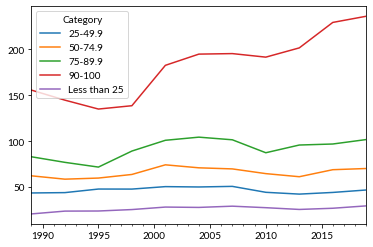

In [34]:
df = (pd.read_csv('../data/scf_wealth_median.csv')
        .set_index(['year', 'Category'])['Before_Tax_Income']
        .unstack())
df.index = pd.to_datetime([f'{year}-07-01' for year in df.index])
df.to_csv(data_dir / 'scfwealthmedian.csv', index_label='date', float_format='%g')
node = end_node(df['Less than 25'], 'violet')
write_txt(text_dir / 'scfwealthmedian_node1.txt', node)
node = end_node(df['25-49.9'], 'red!20!orange!95!black')
write_txt(text_dir / 'scfwealthmedian_node2.txt', node)
node = end_node(df['50-74.9'], 'green!80!blue!85!black')
write_txt(text_dir / 'scfwealthmedian_node3.txt', node)
node = end_node(df['75-89.9'], 'red!80!black')
write_txt(text_dir / 'scfwealthmedian_node4.txt', node)
node = end_node(df['90-100'], 'blue!80!cyan!80!black', 
          date='y', full_year=True)
write_txt(text_dir / 'scfwealthmedian_node5.txt', node)
df.plot();

In [35]:
yr = dtxt(df.index[-1])['year']
pryr = dtxt(df.index[0])['year']

g1val = df['90-100'].iloc[-1] * 1000
g1valpr = df['90-100'].iloc[0] * 1000
g1ch = g1val - g1valpr
g1pc = ((g1val / g1valpr) - 1) * 100

g2val = df['50-74.9'].iloc[-1] * 1000
g2valpr = df['50-74.9'].iloc[0] * 1000
g2ch = g2val - g2valpr
g2pc = ((g2val / g2valpr) - 1) * 100

g3val = df['25-49.9'].iloc[-1] * 1000
g3valpr = df['25-49.9'].iloc[0] * 1000
g3ch = g3val - g3valpr
g3pc = ((g3val / g3valpr) - 1) * 100

g4val = df['Less than 25'].iloc[-1] * 1000
g4valpr = df['Less than 25'].iloc[0] * 1000
g4ch = g4val - g4valpr
g4pc = ((g4val / g4valpr) - 1) * 100

text1 = (f'have a median annual income of \${g1val:,.0f} in {yr} and '+
         f'\${g1valpr:,.0f} in {pryr}, after adjusting for inflation. '+
         f'Median income for the group increased \${g1ch:,.0f}, or '+
         f'{g1pc:.1f} percent, over the 30-year period. ')

write_txt(text_dir / 'income_wealthg1.txt', text1)
print(text1)

text2 = ('In contrast, families in the third quartile of wealth (50th to 74.9th '+
         f'percentiles, mean wealth of \$700,000 in {yr}, see '+
         '{\color{green!80!blue!85!black}\\textbf{---}}) have a median income of '+
         f'\${g2val:,.0f} in {yr} and \${g2valpr:,.0f} in '+
         f'{pryr}, an increase of \${g2ch:,.0f} ({g2pc:.1f} percent). \n\n'+
         'Median income for families in the second quartile (25th to 49.9th '+
         f'percentiles, mean wealth of \$236,000 in {yr}, see '+
         '{\color{red!20!orange!95!black}\\textbf{---}}) increased '+
         f'\${g3ch:,.0f} ({g3pc:,.1f} percent) to '+
         f'\${g3val:,.0f} in {yr}, '+
         f'from \${g3valpr:,.0f} in {pryr}. \n\n For '+
         'the bottom quarter of families by wealth (see {\color{violet}\\textbf{---}}), '+
         f'median income increased \${g4ch:,.0f} or {g4pc:,.1f} '+
         f'percent to \${g4val:,.0f}, '+
         f'over the 30 years ending {yr}. The bottom quarter of families '+
         f'have a negative mean wealth in {yr} and a median wealth of virtually zero. ')
write_txt(text_dir / 'income_wealthg2.txt', text2)
print('\n', text2)

have a median annual income of \$236,203 in 2019 and \$155,693 in 1989, after adjusting for inflation. Median income for the group increased \$80,510, or 51.7 percent, over the 30-year period. 

 In contrast, families in the third quartile of wealth (50th to 74.9th percentiles, mean wealth of \$700,000 in 2019, see {\color{green!80!blue!85!black}\textbf{---}}) have a median income of \$70,250 in 2019 and \$62,277 in 1989, an increase of \$7,973 (12.8 percent). 

Median income for families in the second quartile (25th to 49.9th percentiles, mean wealth of \$236,000 in 2019, see {\color{red!20!orange!95!black}\textbf{---}}) increased \$3,239 (7.4 percent) to \$46,833 in 2019, from \$43,594 in 1989. 

 For the bottom quarter of families by wealth (see {\color{violet}\textbf{---}}), median income increased \$8,766 or 42.2 percent to \$29,525, over the 30 years ending 2019. The bottom quarter of families have a negative mean wealth in 2019 and a median wealth of virtually zero. 


In [36]:
d = {'Black, non-Hispanic': 'Black', 
     'White, non-Hispanic': 'White'}

df = pd.read_csv('../data/scf_race_mean.csv').set_index(['year', 'Category'])['Net_Worth'].unstack()
df = df.rename(d, axis=1)
df.index = pd.to_datetime([f'{year}-07-01' for year in df.index])
df = df.round(1)
df.to_csv(data_dir / 'scfracemean.csv', index_label='date')

In [37]:
df = pd.read_csv('../data/scf_race_mean.csv').set_index(['year', 'Category'])['Before_Tax_Income'].unstack()
df = df.rename(d, axis=1)
df.index = pd.to_datetime([f'{year}-07-01' for year in df.index])
df = df.round(1)
df.to_csv(data_dir / 'scfracemean1.csv', index_label='date')

In [38]:
df = pd.read_csv('../data/scf_race_mean.csv').set_index(['year', 'Category'])['Financial_Assets'].unstack()
df = df.rename(d, axis=1)
df.index = pd.to_datetime([f'{year}-07-01' for year in df.index])
df = df.round(1)
df.to_csv(data_dir / 'scfracemean0.csv', index_label='date')

In [39]:
df = pd.read_csv('../data/scf_race_mean.csv').set_index(['year', 'Category'])['Stock_Holdings'].unstack()
df = df.rename(d, axis=1)
df.index = pd.to_datetime([f'{year}-07-01' for year in df.index])
df = df.round(1)
df.to_csv(data_dir / 'scfracemean2.csv', index_label='date')

wval = df.White.iloc[-1] * 1000
bval = df.Black.iloc[-1] * 1000

df = pd.read_csv('../data/scf_race_have.csv').set_index(['year', 'Category'])['Stock_Holdings'].unstack()
df = df.rename(d, axis=1)
df.index = pd.to_datetime([f'{year}-07-01' for year in df.index])
df = df.round(1)
df.to_csv(data_dir / 'scfracehave.csv', index_label='date')

wp = df.White.iloc[-1]
bp = df.Black.iloc[-1]

yr = dtxt(df.index[-1])['year']

text = (f'In {yr}, among the {wp:.1f} percent of white families who own stocks, '+
        f'the average value of stock holdings is \${wval:,.0f}. The return on these '+
        'assets is a supplement to labor income and the assets themselves provide '+
        'cushion against unexpected expenses. Meanwhile, black families '+
        f'have relatively few financial assets; only {bp:.1f} percent of black '+
        f'families own stocks, with median stock holdings of \${bval:,.0f}.')
write_txt(text_dir / 'scfracestocks.txt', text)
print(text)

In 2019, among the 60.8 percent of white families who own stocks, the average value of stock holdings is \$433,900. The return on these assets is a supplement to labor income and the assets themselves provide cushion against unexpected expenses. Meanwhile, black families have relatively few financial assets; only 33.5 percent of black families own stocks, with median stock holdings of \$76,300.
